<a href="https://colab.research.google.com/github/levantu019/RIT/blob/main/FLY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive for data storage and model saving
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive mounted!")

Mounted at /content/drive
✅ Google Drive mounted!


In [ ]:
"""
Block 1: Environment Setup and Installation
Purpose: Install required packages and import necessary libraries for YOLOv11 plane detection
"""

# Install required packages for YOLOv11 and geospatial processing
print("Installing required packages...")
!pip install ultralytics roboflow pillow opencv-python matplotlib
!pip install rasterio geopandas pyproj shapely

# Import standard libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
import yaml
from PIL import Image
import json
import pandas as pd

# Import YOLOv11 from ultralytics
from ultralytics import YOLO

# Import geospatial libraries for coordinate processing
import rasterio
from rasterio.transform import xy
from rasterio.windows import Window
import geopandas as gpd
from shapely.geometry import Point



print("✅ All packages installed and libraries imported successfully!")


Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 97.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 87.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View 

In [ ]:
# Define the base directory in Google Drive
HOME = '/content/drive/MyDrive/Detection'
PATTERNS = f'{HOME}/original_images'
COLAB_RUN = f'{HOME}/ColabRun_1'

In [ ]:
"""
Block 2: Dataset Preparation and Directory Structure
Purpose: Create proper directory structure and prepare .tif images for YOLO training
"""



def create_dataset_structure():
    """
    Create the required directory structure for YOLO training
    """
    directories = [
        f'{COLAB_RUN}/dataset/images/train',
        f'{COLAB_RUN}/dataset/images/val',
        f'{COLAB_RUN}/dataset/labels/train',
        f'{COLAB_RUN}/dataset/labels/val',
        f'{PATTERNS}',
        f'{COLAB_RUN}/converted_images',
        f'{COLAB_RUN}/results'
    ]

    for directory in directories:
        os.makedirs(directory, exist_ok=True)
        print(f"Created directory: {directory}")

    print("✅ Dataset structure created successfully!")

def upload_tif_images():
    """
    Instructions for uploading .tif plane pattern images
    """
    print("="*60)
    print("UPLOAD YOUR .TIF PLANE PATTERN IMAGES")
    print("="*60)
    print(f"1. Upload your 150 .tif plane pattern images to: {HOME}/original_images/")
    print("2. You can use the file browser on the left side of Colab")
    print("3. Or use the following code to upload programmatically:")
    print("")
    print("from google.colab import files")
    print("uploaded = files.upload()")
    print("")
    print("4. Make sure each .tif file contains one plane pattern")
    print("5. Images can be different sizes - they will be automatically resized")

# Create dataset structure
create_dataset_structure()

# Display upload instructions
upload_tif_images()

Created directory: /content/drive/MyDrive/Detection/ColabRun_1/dataset/images/train
Created directory: /content/drive/MyDrive/Detection/ColabRun_1/dataset/images/val
Created directory: /content/drive/MyDrive/Detection/ColabRun_1/dataset/labels/train
Created directory: /content/drive/MyDrive/Detection/ColabRun_1/dataset/labels/val
Created directory: /content/drive/MyDrive/Detection/original_images
Created directory: /content/drive/MyDrive/Detection/ColabRun_1/converted_images
Created directory: /content/drive/MyDrive/Detection/ColabRun_1/results
✅ Dataset structure created successfully!
UPLOAD YOUR .TIF PLANE PATTERN IMAGES
1. Upload your 150 .tif plane pattern images to: /content/drive/MyDrive/Detection/original_images/
2. You can use the file browser on the left side of Colab
3. Or use the following code to upload programmatically:

from google.colab import files
uploaded = files.upload()

4. Make sure each .tif file contains one plane pattern
5. Images can be different sizes - they w

In [ ]:
"""
Block 3: Image Conversion and Preprocessing
Purpose: Convert .tif images to .jpg format and resize them for YOLO training
"""

def convert_tif_to_jpg(input_dir, output_dir, target_size=640):
    """
    Convert .tif images to .jpg format and resize for YOLO training

    Args:
        input_dir (str): Directory containing .tif images
        output_dir (str): Directory to save converted .jpg images
        target_size (int): Target image size (images will be resized maintaining aspect ratio)

    Returns:
        list: List of successfully converted filenames
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Check if input directory exists
    if not os.path.exists(input_dir):
        print(f"❌ Input directory not found: {input_dir}")
        print("Please upload your .tif images first!")
        return []

    # Get list of .tif files
    tif_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.tif', '.tiff'))]

    if len(tif_files) == 0:
        print(f"❌ No .tif files found in {input_dir}")
        return []

    print(f"Found {len(tif_files)} .tif files to convert...")
    converted_files = []

    for i, filename in enumerate(tif_files):
        print(f"Processing {i+1}/{len(tif_files)}: {filename}")

        # Full path to input image
        img_path = os.path.join(input_dir, filename)

        try:
            # Read .tif image using OpenCV
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)

            if img is None:
                print(f"⚠️  Warning: Could not read {filename}")
                continue

            # Get original dimensions
            original_height, original_width = img.shape[:2]
            print(f"   Original size: {original_width}x{original_height}")

            # Calculate new dimensions while maintaining aspect ratio
            if max(original_height, original_width) > target_size:
                if original_height > original_width:
                    # Height is larger - resize based on height
                    new_height = target_size
                    new_width = int(original_width * target_size / original_height)
                else:
                    # Width is larger - resize based on width
                    new_width = target_size
                    new_height = int(original_height * target_size / original_width)

                # Resize image using high-quality interpolation
                img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
                print(f"   Resized to: {new_width}x{new_height}")
            else:
                new_width, new_height = original_width, original_height
                print(f"   No resizing needed")

            # Generate output filename (replace .tif with .jpg)
            output_filename = filename.replace('.tif', '.jpg').replace('.tiff', '.jpg')
            output_path = os.path.join(output_dir, output_filename)

            # Save as high-quality .jpg
            success = cv2.imwrite(output_path, img, [cv2.IMWRITE_JPEG_QUALITY, 100])

            if success:
                converted_files.append(output_filename)
                print(f"   ✅ Converted: {filename} -> {output_filename}")
            else:
                print(f"   ❌ Failed to save: {output_filename}")

        except Exception as e:
            print(f"   ❌ Error processing {filename}: {str(e)}")
            continue

    print(f"\n✅ Conversion complete! {len(converted_files)}/{len(tif_files)} files converted successfully.")
    return converted_files

# Convert .tif images to .jpg
print("="*60)
print("CONVERTING .TIF IMAGES TO .JPG FORMAT")
print("="*60)

converted_files = convert_tif_to_jpg(f'{HOME}/original_images', f'{COLAB_RUN}/converted_images')

if len(converted_files) == 0:
    print("❌ No files were converted. Please check your .tif images and try again.")
else:
    print(f"✅ Ready for training with {len(converted_files)} plane images!")

CONVERTING .TIF IMAGES TO .JPG FORMAT


In [ ]:
"""
Block 4: Annotation Creation
Purpose: Create YOLO format annotations for plane detection
Since each image contains one plane pattern, we'll create full-image annotations
"""

def create_yolo_annotations(image_dir, label_dir, padding_ratio=0.05):
    """
    Create YOLO format annotations for plane images

    Args:
        image_dir (str): Directory containing images
        label_dir (str): Directory to save label files
        padding_ratio (float): Padding around the plane (0.05 = 5% padding)
    """
    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]

    if len(image_files) == 0:
        print(f"❌ No .jpg files found in {image_dir}")
        return

    print(f"Creating annotations for {len(image_files)} images...")

    for i, img_file in enumerate(image_files):
        # Load image to get dimensions
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"⚠️  Could not read {img_file}")
            continue

        height, width = img.shape[:2]

        # Create corresponding label file name
        label_file = img_file.replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_file)

        # YOLO format: class_id center_x center_y width height (all normalized 0-1)
        # Since each image contains one plane, we'll create a bounding box that covers most of the image

        # Calculate bounding box with padding
        box_width = 1.0 - (2 * padding_ratio)  # Leave some padding
        box_height = 1.0 - (2 * padding_ratio)
        center_x = 0.5  # Center of image
        center_y = 0.5  # Center of image

        # Write annotation file
        with open(label_path, 'w') as f:
            # Class 0 = plane, followed by normalized coordinates
            f.write(f"0 {center_x} {center_y} {box_width} {box_height}\n")

        print(f"   {i+1}/{len(image_files)}: Created annotation for {img_file}")

    print(f"✅ Created {len(image_files)} annotation files")

def visualize_annotations(dataset_path, num_samples=4):
    """
    Visualize sample images with their annotations to verify correctness

    Args:
        dataset_path (str): Path to dataset directory
        num_samples (int): Number of samples to display
    """
    train_img_dir = os.path.join(dataset_path, 'images/train')
    train_label_dir = os.path.join(dataset_path, 'labels/train')

    # Get sample image files
    img_files = [f for f in os.listdir(train_img_dir) if f.endswith('.jpg')][:num_samples]

    if len(img_files) == 0:
        print("❌ No images found for visualization")
        return

    # Create subplot grid
    cols = 2
    rows = (num_samples + 1) // 2
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))

    if num_samples == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, img_file in enumerate(img_files):
        if i >= num_samples:
            break

        # Load image
        img_path = os.path.join(train_img_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

        # Load corresponding label
        label_file = img_file.replace('.jpg', '.txt')
        label_path = os.path.join(train_label_dir, label_file)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            height, width = img.shape[:2]

            # Draw bounding boxes
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, center_x, center_y, box_width, box_height = map(float, parts)

                    # Convert normalized coordinates to pixel coordinates
                    x_center_pixel = int(center_x * width)
                    y_center_pixel = int(center_y * height)
                    box_width_pixel = int(box_width * width)
                    box_height_pixel = int(box_height * height)

                    # Calculate corner coordinates
                    x1 = int(x_center_pixel - box_width_pixel/2)
                    y1 = int(y_center_pixel - box_height_pixel/2)
                    x2 = int(x_center_pixel + box_width_pixel/2)
                    y2 = int(y_center_pixel + box_height_pixel/2)

                    # Draw bounding box
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
                    cv2.putText(img, 'PLANE', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

                    # Draw center point
                    cv2.circle(img, (x_center_pixel, y_center_pixel), 5, (0, 255, 0), -1)

        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f'Sample {i+1}: {img_file}', fontsize=10)
        axes[i].axis('off')

    # Hide unused subplots
    for i in range(len(img_files), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    print("✅ Annotation visualization complete!")

# This block will be used after data splitting
print("✅ Annotation creation functions ready!")
print("   Annotations will be created after data splitting in the next block.")

✅ Annotation creation functions ready!
   Annotations will be created after data splitting in the next block.


SPLITTING DATASET INTO TRAIN/VALIDATION
Found 153 images for dataset splitting
Dataset split:
   Training images: 122 (79.7%)
   Validation images: 31 (20.3%)

Copying training images...
   Copied 20/122 training images
   Copied 40/122 training images
   Copied 60/122 training images
   Copied 80/122 training images
   Copied 100/122 training images
   Copied 120/122 training images
   Copied 122/122 training images

Copying validation images...
   Copied 1/31 validation images
   Copied 2/31 validation images
   Copied 3/31 validation images
   Copied 4/31 validation images
   Copied 5/31 validation images
   Copied 6/31 validation images
   Copied 7/31 validation images
   Copied 8/31 validation images
   Copied 9/31 validation images
   Copied 10/31 validation images
   Copied 11/31 validation images
   Copied 12/31 validation images
   Copied 13/31 validation images
   Copied 14/31 validation images
   Copied 15/31 validation images
   Copied 16/31 validation images
   Copied 17/3

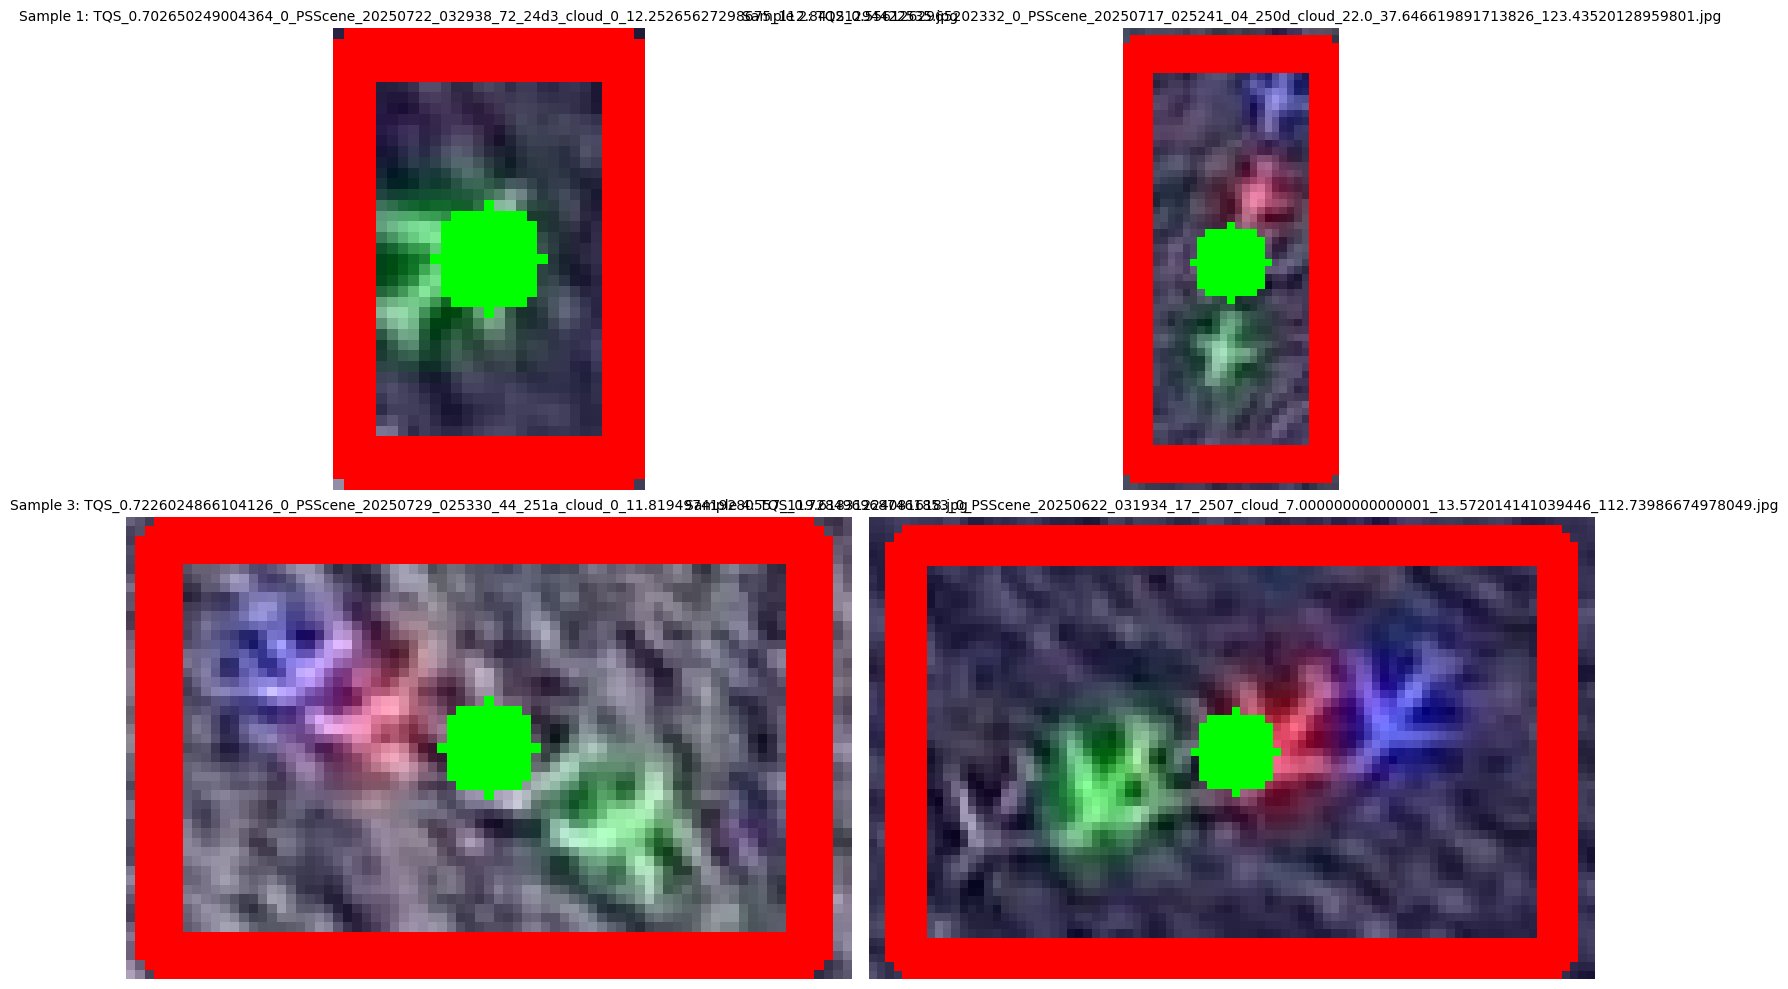

✅ Annotation visualization complete!


In [ ]:
"""
Block 5: Dataset Splitting
Purpose: Split the converted images into training and validation sets
"""

def split_and_organize_dataset(source_dir, train_ratio=0.8, random_seed=42):
    """
    Split images into train/val sets and organize them in YOLO format

    Args:
        source_dir (str): Directory containing converted .jpg images
        train_ratio (float): Ratio of images for training (0.8 = 80%)
        random_seed (int): Random seed for reproducible splits
    """
    # Set random seed for reproducible results
    random.seed(random_seed)

    # Check if source directory exists
    if not os.path.exists(source_dir):
        print(f"❌ Source directory not found: {source_dir}")
        return [], []

    # Get all .jpg files
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith('.jpg')]

    if len(image_files) == 0:
        print("❌ No .jpg files found in source directory")
        return [], []

    print(f"Found {len(image_files)} images for dataset splitting")

    # Shuffle images randomly
    random.shuffle(image_files)

    # Calculate split
    train_count = int(len(image_files) * train_ratio)
    train_files = image_files[:train_count]
    val_files = image_files[train_count:]

    # Ensure we have at least 1 validation image
    if len(val_files) == 0 and len(train_files) > 1:
        val_files = [train_files.pop()]
        print("⚠️  Moved one image to validation set to ensure validation data exists")

    print(f"Dataset split:")
    print(f"   Training images: {len(train_files)} ({len(train_files)/len(image_files)*100:.1f}%)")
    print(f"   Validation images: {len(val_files)} ({len(val_files)/len(image_files)*100:.1f}%)")

    # Copy images to respective directories
    print("\nCopying training images...")
    for i, img_file in enumerate(train_files):
        src_path = os.path.join(source_dir, img_file)
        dst_path = f'{COLAB_RUN}/dataset/images/train/{img_file}'
        try:
            shutil.copy2(src_path, dst_path)
            if (i + 1) % 20 == 0 or (i + 1) == len(train_files):
                print(f"   Copied {i + 1}/{len(train_files)} training images")
        except Exception as e:
            print(f"   ❌ Error copying {img_file} to train: {e}")

    print("\nCopying validation images...")
    for i, img_file in enumerate(val_files):
        src_path = os.path.join(source_dir, img_file)
        dst_path = f'{COLAB_RUN}/dataset/images/val/{img_file}'
        try:
            shutil.copy2(src_path, dst_path)
            print(f"   Copied {i + 1}/{len(val_files)} validation images")
        except Exception as e:
            print(f"   ❌ Error copying {img_file} to val: {e}")

    print("✅ Dataset splitting and organization complete!")
    return train_files, val_files

# Perform dataset splitting
print("="*60)
print("SPLITTING DATASET INTO TRAIN/VALIDATION")
print("="*60)

train_files, val_files = split_and_organize_dataset(f'{COLAB_RUN}/converted_images', train_ratio=0.8)

if len(train_files) > 0:
    # Create annotations for both training and validation sets
    print("\n" + "="*60)
    print("CREATING YOLO ANNOTATIONS")
    print("="*60)

    print("Creating training annotations...")
    create_yolo_annotations(f'{COLAB_RUN}/dataset/images/train', f'{COLAB_RUN}/dataset/labels/train')

    print("\nCreating validation annotations...")
    create_yolo_annotations(f'{COLAB_RUN}/dataset/images/val', f'{COLAB_RUN}/dataset/labels/val')

    # Visualize some training samples
    print("\n" + "="*60)
    print("VISUALIZING TRAINING SAMPLES")
    print("="*60)
    visualize_annotations(f'{COLAB_RUN}/dataset', num_samples=4)

else:
    print("❌ No training files available. Please check the previous steps.")

In [ ]:
"""
Block 6: Dataset Configuration
Purpose: Create YOLO dataset configuration file (data.yaml)
"""

def create_dataset_config():
    """
    Create YOLO dataset configuration file
    """
    # Dataset configuration for YOLO
    data_config = {
        'path': f'{COLAB_RUN}/dataset',  # Root directory of dataset
        'train': 'images/train',     # Training images directory (relative to path)
        'val': 'images/val',         # Validation images directory (relative to path)
        'nc': 1,                     # Number of classes
        'names': ['plane']           # Class names (class 0 = plane)
    }

    # Save configuration to YAML file
    config_path = f'{COLAB_RUN}/dataset/data.yaml'
    with open(config_path, 'w') as f:
        yaml.dump(data_config, f, default_flow_style=False)

    print("✅ Dataset configuration created!")
    print(f"   Config file: {config_path}")
    print(f"   Classes: {data_config['nc']} (plane)")
    print(f"   Training path: {data_config['path']}/{data_config['train']}")
    print(f"   Validation path: {data_config['path']}/{data_config['val']}")

    return config_path

def verify_dataset_structure():
    """
    Verify that dataset structure is correct for YOLO training
    """
    print("\n" + "="*60)
    print("VERIFYING DATASET STRUCTURE")
    print("="*60)

    # Check required directories
    required_dirs = [
        f'{COLAB_RUN}/dataset/images/train',
        f'{COLAB_RUN}/dataset/images/val', # Corrected path
        f'{COLAB_RUN}/dataset/labels/train', # Corrected path
        f'{COLAB_RUN}/dataset/labels/val' # Corrected path
    ]

    for directory in required_dirs:
        if os.path.exists(directory):
            file_count = len([f for f in os.listdir(directory) if not f.startswith('.')])
            print(f"✅ {directory}: {file_count} files")
        else:
            print(f"❌ Missing: {directory}")
            return False

    # Check that data.yaml exists
    if os.path.exists(f'{COLAB_RUN}/dataset/data.yaml'):
        print("✅ Dataset configuration file: data.yaml")
    else:
        print("❌ Missing: data.yaml")
        return False

    # Verify matching image/label pairs
    train_images = set([f.replace('.jpg', '') for f in os.listdir(f'{COLAB_RUN}/dataset/images/train') if f.endswith('.jpg')])
    train_labels = set([f.replace('.txt', '') for f in os.listdir(f'{COLAB_RUN}/dataset/labels/train') if f.endswith('.txt')])

    val_images = set([f.replace('.jpg', '') for f in os.listdir(f'{COLAB_RUN}/dataset/images/val') if f.endswith('.jpg')])
    val_labels = set([f.replace('.txt', '') for f in os.listdir(f'{COLAB_RUN}/dataset/labels/val') if f.endswith('.txt')])

    if train_images == train_labels:
        print(f"✅ Training set: {len(train_images)} matching image/label pairs")
    else:
        print(f"❌ Training set: Mismatched image/label pairs")
        # return False # Allow verification to continue even with mismatch for clearer output

    if val_images == val_labels:
        print(f"✅ Validation set: {len(val_images)} matching image/label pairs")
    else:
        print(f"❌ Validation set: Mismatched image/label pairs")
        # return False # Allow verification to continue even with mismatch for clearer output

    print("\n✅ Dataset structure verification complete!")
    print("   Dataset is ready for YOLO training!")
    return True # Return True if data.yaml exists and directories are present

# Create dataset configuration
config_path = create_dataset_config()

# Verify dataset structure
dataset_ready = verify_dataset_structure()

if not dataset_ready:
    print("\n❌ Dataset structure issues detected. Please fix before training.")
else:
    # Need to re-calculate train_files length as it's not globally available here
    try:
        train_files_count = len([f for f in os.listdir(f'{COLAB_RUN}/dataset/images/train') if f.endswith('.jpg')])
        print(f"\n🎯 Dataset ready for training with {train_files_count} training images!")
    except FileNotFoundError:
         print("\n🎯 Dataset ready for training but training image directory not found.")

✅ Dataset configuration created!
   Config file: /content/drive/MyDrive/Detection/ColabRun_1/dataset/data.yaml
   Classes: 1 (plane)
   Training path: /content/drive/MyDrive/Detection/ColabRun_1/dataset/images/train
   Validation path: /content/drive/MyDrive/Detection/ColabRun_1/dataset/images/val

VERIFYING DATASET STRUCTURE
✅ /content/drive/MyDrive/Detection/ColabRun_1/dataset/images/train: 122 files
✅ /content/drive/MyDrive/Detection/ColabRun_1/dataset/images/val: 31 files
✅ /content/drive/MyDrive/Detection/ColabRun_1/dataset/labels/train: 122 files
✅ /content/drive/MyDrive/Detection/ColabRun_1/dataset/labels/val: 31 files
✅ Dataset configuration file: data.yaml
✅ Training set: 122 matching image/label pairs
✅ Validation set: 31 matching image/label pairs

✅ Dataset structure verification complete!
   Dataset is ready for YOLO training!

🎯 Dataset ready for training with 122 training images!


In [ ]:
"""
Block 7: Model Training
Purpose: Train YOLOv11 model for plane detection with optimized settings
"""



def train_yolo_plane_detection(epochs=250, imgsz=640, batch_size=16):
    """
    Train YOLOv11 model for plane detection

    Args:
        epochs (int): Number of training epochs
        imgsz (int): Input image size
        batch_size (int): Batch size for training
    """
    print("="*60)
    print("STARTING YOLOv11 PLANE DETECTION TRAINING")
    print("="*60)

    # Check GPU availability
    import torch
    if torch.cuda.is_available():
        print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
        print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        device = 0
    else:
        print("⚠️  GPU not available - using CPU (training will be slower)")
        device = 'cpu'

    # Initialize YOLOv11 model
    print(f"\nInitializing YOLOv11 model...")
    # Using nano version for faster training with small dataset
    # Consider using 'yolo11s.pt' (small) or 'yolo11m.pt' (medium) for potentially better accuracy
    # if you have a larger dataset and more time/resources.
    model = YOLO('yolo11n.pt') # Changed back to nano as per conversation flow
    print("✅ Model initialized")

    # Training parameters optimized for plane detection
    print(f"\nTraining parameters:")
    print(f"   Epochs: {epochs}")
    print(f"   Image size: {imgsz}")
    print(f"   Batch size: {batch_size}")
    print(f"   Device: {device}")

    try:
        # Start training
        print(f"\n🚀 Starting training...")
        results = model.train(
            # Data and paths
            data=f'{COLAB_RUN}/dataset/data.yaml',     # Path to dataset config

            # Training parameters
            epochs=epochs,                          # Number of training epochs
            imgsz=imgsz,                           # Input image size
            batch=batch_size,                      # Batch size

            # Learning rate settings
            lr0=0.01,                              # Initial learning rate
            lrf=0.01,                              # Final learning rate (lr0 * lrf)
            momentum=0.937,                        # SGD momentum
            weight_decay=0.0005,                   # Weight decay for regularization
            warmup_epochs=3,                       # Warmup learning rate epochs
            warmup_momentum=0.8,                   # Warmup momentum

            # Data augmentation (important for satellite imagery)
            mosaic=1.0,                            # Mosaic augmentation probability
            mixup=0.15,                            # Mixup augmentation probability
            copy_paste=0.1,                        # Copy-paste augmentation probability
            degrees=0,                             # Rotation range (degrees)
            translate=0.1,                         # Translation range
            scale=0.5,                             # Scaling range
            shear=0,                               # Shear range
            perspective=0.0,                       # Perspective transformation range
            fliplr=0.5,                            # Horizontal flip probability
            flipud=0.0,                            # Vertical flip probability (careful with planes)

            # Color augmentations
            hsv_h=0.015,                           # Hue augmentation range
            hsv_s=0.7,                             # Saturation augmentation range
            hsv_v=0.4,                             # Value (brightness) augmentation range

            # Optimizer and scheduler
            optimizer='auto',                       # Optimizer (auto selects best)
            cos_lr=False,                          # Use cosine learning rate scheduler
            close_mosaic=10,                       # Disable mosaic in last N epochs

            # Hardware and performance
            device=device,                         # Training device
            workers=8,                             # Number of data loading workers

            # Validation and saving
            val=True,                              # Validate during training
            save=True,                             # Save training checkpoints
            save_period=-1,                        # Save checkpoint every N epochs (-1 = only last)
            cache=False,                           # Cache images for faster training

            # Output settings
            project=f'{COLAB_RUN}/runs/detect',        # Project directory (can keep local for Colab run output)
            name='plane_detection',                # Experiment name
            exist_ok=True,                         # Allow overwriting existing experiment

            # Advanced settings
            patience=100,                           # Early stopping patience - increased to allow longer training
            plots=True,                            # Generate training plots
            verbose=True,                          # Verbo se output
            seed=0,                                # Random seed for reproducibility
            deterministic=True,                    # Deterministic training
            single_cls=True,                       # Single class training optimization
            rect=False,                            # Rectangular training
            resume=False,                          # Resume from last checkpoint
            amp=True,                              # Automatic Mixed Precision
        )

        print("\n✅ Training completed successfully!")
        return model, results

    except Exception as e:
        print(f"\n❌ Training failed with error: {str(e)}")
        return None, None

def evaluate_model_performance(model):
    """
    Evaluate the trained model performance

    Args:
        model: Trained YOLO model
    """
    print("\n" + "="*60)
    print("EVALUATING MODEL PERFORMANCE")
    print("="*60)

    # Run validation
    try:
        metrics = model.val()

        # Extract key metrics
        map50 = metrics.box.map50      # mAP at IoU=0.5
        map50_95 = metrics.box.map     # mAP at IoU=0.5:0.95
        precision = metrics.box.mp     # Mean precision
        recall = metrics.box.mr        # Mean recall

        print(f"📊 Model Performance Metrics:")
        print(f"   mAP@0.5:     {map50:.3f} ({map50*100:.1f}%)")
        print(f"   mAP@0.5:0.95: {map50_95:.3f} ({map50_95*100:.1f}%)")
        print(f"   Precision:   {precision:.3f} ({precision*100:.1f}%)")
        print(f"   Recall:      {recall:.3f} ({recall*100:.1f}%)")

        # Performance interpretation
        if map50 > 0.9:
            print("\n🎉 Excellent performance! (mAP@0.5 > 90%)")
        elif map50 > 0.8:
            print("\n✅ Good performance! (mAP@0.5 > 80%)")
        elif map50 > 0.7:
            print("\n👍 Decent performance (mAP@0.5 > 70%)")
        else:
            print("\n⚠️  Performance could be improved (mAP@0.5 < 70%)")
            print("   Consider training for more epochs or adjusting hyperparameters")

        return metrics

    except Exception as e:
        print(f"❌ Evaluation failed: {str(e)}")
        return None

# Check if dataset is ready before training
# Need to get the count of training files from the directory directly
try:
    train_files_count = len([f for f in os.listdir(f'{COLAB_RUN}/dataset/images/train') if f.endswith('.jpg')])
except FileNotFoundError:
    train_files_count = 0
    print(f"⚠️  Training image directory not found: f'{COLAB_RUN}/dataset/images/train")


if 'dataset_ready' in locals() and dataset_ready and train_files_count > 0:
    print("🎯 Starting model training...")

    # Adjust batch size based on dataset size
    dataset_size = train_files_count
    if dataset_size < 50:
        batch_size = 4
        epochs_to_train = 300 # Increased epochs
    elif dataset_size < 100:
        batch_size = 8
        epochs_to_train = 400 # Increased epochs
    else:
        batch_size = 16
        epochs_to_train = 500 # Increased epochs (allowing for potentially longer training)

    print(f"   Adjusted for dataset size ({dataset_size} images):")
    print(f"   Batch size: {batch_size}, Epochs: {epochs_to_train}")

    # Train the model
    model, results = train_yolo_plane_detection(epochs=epochs_to_train, batch_size=batch_size)

    if model is not None:
        # Evaluate model performance
        metrics = evaluate_model_performance(model)

        # Save model to Google Drive
        model_save_path = f'{COLAB_RUN}/yolo11_plane_detection_model_optimized.pt'
        model.save(model_save_path)
        print(f"\n💾 Model saved to: {model_save_path}")
        print("✅ Training pipeline completed successfully!")

    else:
        print("❌ Training failed - model not available")

else:
    print("❌ Dataset not ready or no training files available")
    print("   Please run the previous blocks to prepare your dataset")

🎯 Starting model training...
   Adjusted for dataset size (122 images):
   Batch size: 16, Epochs: 500
STARTING YOLOv11 PLANE DETECTION TRAINING
✅ GPU available: Tesla T4
   GPU Memory: 15.8 GB

Initializing YOLOv11 model...
✅ Model initialized

Training parameters:
   Epochs: 500
   Image size: 640
   Batch size: 16
   Device: 0

🚀 Starting training...
Ultralytics 8.3.188 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Detection/ColabRun_1/dataset/data.yaml, degrees=0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=500, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv

In [ ]:
"""
Block 8: Geospatial Detection Functions
Purpose: Functions to detect planes in satellite images and extract spatial coordinates
"""



def extract_geospatial_info(image_path):
    """
    Extract geospatial information from satellite image (.tif)

    Args:
        image_path (str): Path to the satellite image

    Returns:
        dict: Geospatial information including CRS, transform, bounds
    """
    try:
        with rasterio.open(image_path) as src:
            return {
                'has_geospatial': True,
                'crs': src.crs,                    # Coordinate Reference System
                'transform': src.transform,         # Pixel to world coordinate transformation
                'bounds': src.bounds,              # Geographic bounds (left, bottom, right, top)
                'width': src.width,                # Image width in pixels
                'height': src.height,              # Image height in pixels
                'pixel_size_x': src.transform[0],  # Pixel size in X direction (meters/degrees)
                'pixel_size_y': abs(src.transform[4]),  # Pixel size in Y direction (meters/degrees)
                'units': 'meters' if src.crs and 'utm' in str(src.crs).lower() else 'degrees'
            }
    except Exception as e:
        print(f"⚠️  Could not extract geospatial info: {e}")
        return {'has_geospatial': False, 'error': str(e)}

def pixel_to_world_coordinates(pixel_x, pixel_y, geospatial_info):
    """
    Convert pixel coordinates to world coordinates (latitude/longitude or UTM)

    Args:
        pixel_x (int): X coordinate in pixels
        pixel_y (int): Y coordinate in pixels
        geospatial_info (dict): Geospatial information from extract_geospatial_info

    Returns:
        tuple: (world_x, world_y) or (None, None) if conversion fails
    """
    if not geospatial_info['has_geospatial']:
        return None, None

    try:
        # Use rasterio transform to convert pixel to world coordinates
        transform = geospatial_info['transform']
        world_x, world_y = xy(transform, pixel_y, pixel_x)  # Note: y, x order for rasterio
        return float(world_x), float(world_y)
    except Exception as e:
        print(f"Error converting coordinates: {e}")
        return None, None

def detect_planes_with_coordinates(model_path, original_tif_path, converted_jpg_path, confidence_threshold=0.25, output_dir=f'{COLAB_RUN}/results'):
    """
    Detect planes in satellite image and return results with spatial coordinates

    Args:
        model_path (str): Path to trained YOLO model
        original_tif_path (str): Path to the original satellite image (.tif) for geospatial info
        converted_jpg_path (str): Path to the converted .jpg image for detection
        confidence_threshold (float): Minimum confidence for detections
        output_dir (str): Directory to save results

    Returns:
        dict: Detection results with spatial coordinates
    """
    print("="*80)
    print("PLANE DETECTION WITH SPATIAL COORDINATES")
    print("="*80)
    print(f"📷 Original satellite image (.tif): {original_tif_path}")
    print(f"🖼️ Converted image (.jpg): {converted_jpg_path}")
    print(f"🤖 Model: {model_path}")
    print(f"🎯 Confidence threshold: {confidence_threshold}")

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Extract geospatial information from the original TIF
    print("\n📍 Extracting geospatial information from TIF...")
    geospatial_info = extract_geospatial_info(original_tif_path)

    if geospatial_info['has_geospatial']:
        print("✅ Geospatial information found:")
        print(f"   CRS: {geospatial_info['crs']}")
        # Use original TIF dimensions for coordinate conversion
        print(f"   Original TIF size: {geospatial_info['width']} x {geospatial_info['height']} pixels")
        print(f"   Pixel size: {geospatial_info['pixel_size_x']:.2f} x {geospatial_info['pixel_size_y']:.2f} {geospatial_info['units']}")
        if geospatial_info['bounds']:
            bounds = geospatial_info['bounds']
            print(f"   Bounds: ({bounds.left:.6f}, {bounds.bottom:.6f}) to ({bounds.right:.6f}, {bounds.top:.6f})")
    else:
        print("⚠️  No geospatial information found in TIF - only pixel coordinates will be available")
        # Attempt to get image dimensions from JPG for pixel coordinates if TIF fails
        try:
             img_jpg = cv2.imread(converted_jpg_path)
             if img_jpg is not None:
                 geospatial_info['width'] = img_jpg.shape[1]
                 geospatial_info['height'] = img_jpg.shape[0]
                 print(f"   Using JPG dimensions for pixel coordinates: {geospatial_info['width']} x {geospatial_info['height']} pixels")
             else:
                 print(f"❌ Could not read JPG image to get dimensions: {converted_jpg_path}")
                 return None # Cannot proceed without dimensions
        except Exception as e:
            print(f"❌ Error reading JPG image for dimensions: {e}")
            return None


    # Load the trained model
    print(f"\n🤖 Loading model...")
    try:
        model = YOLO(model_path)
        print("✅ Model loaded successfully")
    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        return None

    # Run inference on the converted JPG image
    print(f"\n🔍 Running plane detection on JPG image...")
    try:
        # Run inference on the converted JPG image
        results = model(converted_jpg_path, conf=confidence_threshold, save=False)
        print("✅ Detection completed")
    except Exception as e:
        print(f"❌ Detection failed: {e}")
        return None

    # Process detection results
    detection_results = []

    for result in results:
        boxes = result.boxes

        if boxes is not None and len(boxes) > 0:
            print(f"\n🎯 Found {len(boxes)} plane detection(s)!")

            # Get the dimensions of the image used for detection (the JPG)
            # This is needed to correctly interpret the YOLO output (normalized coordinates)
            detection_img_height, detection_img_width = result.orig_shape # Use orig_shape from YOLO result

            for i, box in enumerate(boxes):
                # Extract detection information from JPG coordinates
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Bounding box coordinates in JPG pixels
                confidence = float(box.conf.cpu().numpy()[0])  # Confidence score
                class_id = int(box.cls.cpu().numpy()[0])       # Class ID
                class_name = model.names[class_id]             # Class name

                # Calculate center point in JPG pixel coordinates
                center_x_jpg = int((x1 + x2) / 2)
                center_y_jpg = int((y1 + y2) / 2)

                # --- Coordinate Conversion ---
                # Need to map JPG pixel coordinates back to original TIF pixel coordinates
                # This requires knowing the relationship (scaling and offset) between the TIF and JPG.
                # Since the conversion function `convert_tif_to_jpg` resizes while maintaining aspect ratio
                # and doesn't crop, we can calculate the scaling factor.
                # If the JPG was resized, the scaling factor is:
                # scale_x = detection_img_width / original_tif_width
                # scale_y = detection_img_height / original_tif_height
                # However, the `convert_tif_to_jpg` function scales based on the largest dimension to a target size.
                # A more robust approach is to use the original TIF dimensions extracted earlier and assume the JPG covers the same area,
                # or ideally, calculate the scaling used during conversion precisely.
                # For now, let's assume a simple scaling based on the ratio of dimensions if resizing occurred.

                original_tif_width = geospatial_info.get('width')
                original_tif_height = geospatial_info.get('height')

                if original_tif_width is not None and original_tif_height is not None:
                    # Calculate scaling factor applied during conversion
                    scale_x = original_tif_width / detection_img_width
                    scale_y = original_tif_height / detection_img_height

                    # Convert JPG pixel coordinates to original TIF pixel coordinates
                    center_x_tif = int(center_x_jpg * scale_x)
                    center_y_tif = int(center_y_jpg * scale_y)

                    # Convert TIF pixel coordinates to world coordinates
                    world_x, world_y = pixel_to_world_coordinates(
                        center_x_tif, center_y_tif, geospatial_info
                    )
                else:
                     # Fallback: If TIF dimensions aren't available, just use JPG pixel coordinates
                     print("⚠️ Original TIF dimensions not available for precise coordinate mapping.")
                     center_x_tif = center_x_jpg
                     center_y_tif = center_y_jpg
                     world_x, world_y = None, None # Cannot calculate world coordinates without TIF info


                # Create detection record
                detection = {
                    'detection_id': i + 1,
                    'class_name': class_name,
                    'confidence': round(confidence, 3),
                    'pixel_coordinates_jpg': { # Store JPG pixel coords
                        'center_x': center_x_jpg,
                        'center_y': center_y_jpg,
                        'bbox': {
                            'x1': int(x1), 'y1': int(y1),
                            'x2': int(x2), 'y2': int(y2)
                        }
                    },
                    'pixel_coordinates_tif': { # Store estimated TIF pixel coords
                        'center_x': center_x_tif,
                        'center_y': center_y_tif,
                         # Bbox in TIF pixels is less reliable without knowing the exact padding/resizing logic
                         # but we can estimate based on scaling
                        'bbox': {
                             'x1': int(x1 * scale_x) if original_tif_width is not None else None,
                             'y1': int(y1 * scale_y) if original_tif_height is not None else None,
                             'x2': int(x2 * scale_x) if original_tif_width is not None else None,
                             'y2': int(y2 * scale_y) if original_tif_height is not None else None
                        }
                    }
                }

                # Add world coordinates if available
                if world_x is not None and world_y is not None:
                    if geospatial_info.get('units') == 'degrees':
                        detection['geographic_coordinates'] = {
                            'latitude': round(world_y, 8),
                            'longitude': round(world_x, 8),
                            'crs': str(geospatial_info['crs'])
                        }
                        coord_str = f"({world_y:.6f}°N, {world_x:.6f}°E)"
                    else:
                        detection['projected_coordinates'] = {
                            'x': round(world_x, 2),
                            'y': round(world_y, 2),
                            'crs': str(geospatial_info['crs']),
                            'units': geospatial_info['units']
                        }
                        coord_str = f"({world_x:.1f}, {world_y:.1f}) {geospatial_info['units']}"
                else:
                    coord_str = "No spatial coordinates (TIF info missing)"

                detection_results.append(detection)

                # Print detection details
                print(f"\n   Detection #{i + 1}:")
                print(f"   Class: {class_name}")
                print(f"   Confidence: {confidence:.1%}")
                print(f"   Pixel center (JPG): ({center_x_jpg}, {center_y_jpg})")
                if original_tif_width is not None:
                    print(f"   Pixel center (TIF est.): ({center_x_tif}, {center_y_tif})")
                print(f"   World coordinates: {coord_str}")
        else:
            print("\n❌ No planes detected in the image")

    # Save results
    if detection_results:
        # Prepare results summary
        results_summary = {
            'input_image_tif': original_tif_path,
            'input_image_jpg': converted_jpg_path,
            'model_used': model_path,
            'detection_settings': {
                'confidence_threshold': confidence_threshold,
                'model_version': 'YOLOv11'
            },
            'geospatial_info': geospatial_info,
            'detections': detection_results,
            'summary': {
                'total_detections': len(detection_results),
                'has_spatial_coordinates': geospatial_info['has_geospatial']
            }
        }

        # Save JSON results
        json_path = os.path.join(output_dir, 'detection_results.json')
        with open(json_path, 'w') as f:
            json.dump(results_summary, f, indent=2, default=str)
        print(f"\n💾 Results saved to: {json_path}")

        # Create and save CSV
        csv_data = []
        for detection in detection_results:
            row = {
                'detection_id': detection['detection_id'],
                'class_name': detection['class_name'],
                'confidence': detection['confidence'],
                'pixel_center_x_jpg': detection['pixel_coordinates_jpg']['center_x'],
                'pixel_center_y_jpg': detection['pixel_coordinates_jpg']['center_y'],
                 'pixel_center_x_tif_est': detection['pixel_coordinates_tif']['center_x'],
                 'pixel_center_y_tif_est': detection['pixel_coordinates_tif']['center_y']
            }

            if 'geographic_coordinates' in detection:
                row['latitude'] = detection['geographic_coordinates']['latitude']
                row['longitude'] = detection['geographic_coordinates']['longitude']
                row['crs'] = detection['geographic_coordinates']['crs']
            elif 'projected_coordinates' in detection:
                row['world_x'] = detection['projected_coordinates']['x']
                row['world_y'] = detection['projected_coordinates']['y']
                row['crs'] = detection['projected_coordinates']['crs']
                row['units'] = detection['projected_coordinates']['units']

            csv_data.append(row)

        # Save CSV
        if csv_data:
            df = pd.DataFrame(csv_data)
            csv_path = os.path.join(output_dir, 'detection_results.csv')
            df.to_csv(csv_path, index=False)
            print(f"💾 CSV results saved to: {csv_path}")

        return results_summary

    else:
        print("\n❌ No detections to save")
        return None

print("✅ Geospatial detection functions loaded!")
print(f"   Detection results will be saved in: f'{COLAB_RUN}/results'")
print("   Use detect_planes_with_coordinates() to detect planes with spatial coordinates")

✅ Geospatial detection functions loaded!
   Detection results will be saved in: f'/content/drive/MyDrive/Detection/ColabRun_1/results'
   Use detect_planes_with_coordinates() to detect planes with spatial coordinates


In [ ]:
"""
Block 9: Plane Extraction Function
Purpose: Extract individual plane images from satellite image based on detection results
"""


def extract_plane_images(satellite_image_path, detection_results, output_dir=f'{COLAB_RUN}/results/extracted_planes', padding_ratio=0.2):
    """
    Extract individual plane images from satellite image based on detection results

    Args:
        satellite_image_path (str): Path to original satellite image
        detection_results (dict): Results from detect_planes_with_coordinates
        output_dir (str): Directory to save extracted plane images
        padding_ratio (float): Additional padding around detected planes (0.2 = 20% padding)

    Returns:
        list: List of extracted plane image paths
    """
    print("\n" + "="*80)
    print("EXTRACTING INDIVIDUAL PLANE IMAGES")
    print("="*80)

    if not detection_results or not detection_results.get('detections'):
        print("❌ No detections available for extraction")
        return []

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Read the original satellite image
    print(f"📷 Loading satellite image: {satellite_image_path}")
    try:
        # Read with rasterio to preserve geospatial information
        with rasterio.open(satellite_image_path) as src:
            # Read image data
            image_data = src.read()  # Shape: (bands, height, width)
            profile = src.profile    # Geospatial metadata
            transform = src.transform

        # Convert to OpenCV format (height, width, bands)
        if len(image_data.shape) == 3:
            # Multi-band image
            opencv_image = np.transpose(image_data, (1, 2, 0))
        else:
            # Single band image
            opencv_image = image_data[0]

        print(f"✅ Image loaded: {opencv_image.shape}")

    except Exception as e:
        print(f"❌ Failed to load satellite image: {e}")
        return []

    extracted_paths = []
    geospatial_info = detection_results.get('geospatial_info', {})

    print(f"\n🎯 Extracting {len(detection_results['detections'])} detected planes...")

    for i, detection in enumerate(detection_results['detections']):
        detection_id = detection['detection_id']
        confidence = detection['confidence']

        # Get bounding box coordinates - prioritize TIF coordinates if available
        if 'pixel_coordinates_tif' in detection and detection['pixel_coordinates_tif'].get('bbox') and None not in detection['pixel_coordinates_tif']['bbox'].values():
             bbox = detection['pixel_coordinates_tif']['bbox']
             center_x = detection['pixel_coordinates_tif']['center_x']
             center_y = detection['pixel_coordinates_tif']['center_y']
             print(f"   Using TIF estimated pixel coordinates for detection #{detection_id}")
        elif 'pixel_coordinates_jpg' in detection:
             bbox = detection['pixel_coordinates_jpg']['bbox']
             center_x = detection['pixel_coordinates_jpg']['center_x']
             center_y = detection['pixel_coordinates_jpg']['center_y']
             print(f"   Using JPG pixel coordinates for detection #{detection_id}")
        else:
             print(f"⚠️  Skipping extraction for detection #{detection_id} due to missing pixel coordinates.")
             continue


        x1, y1 = bbox['x1'], bbox['y1']
        x2, y2 = bbox['x2'], bbox['y2']

        # Calculate bounding box dimensions
        bbox_width = x2 - x1
        bbox_height = y2 - y1

        # Add padding
        padding_x = int(bbox_width * padding_ratio)
        padding_y = int(bbox_height * padding_ratio)

        # Calculate padded coordinates, ensuring they stay within image bounds
        padded_x1 = max(0, x1 - padding_x)
        padded_y1 = max(0, y1 - padding_y)
        padded_x2 = min(opencv_image.shape[1], x2 + padding_x)
        padded_y2 = min(opencv_image.shape[0], y2 + padding_y)

        # Extract the plane region
        if len(opencv_image.shape) == 3:
            # Multi-band image
            plane_image = opencv_image[padded_y1:padded_y2, padded_x1:padded_x2, :]
        else:
            # Single band image
            plane_image = opencv_image[padded_y1:padded_y2, padded_x1:padded_x2]

        # Generate filename with coordinates
        if 'geographic_coordinates' in detection:
            lat = detection['geographic_coordinates']['latitude']
            lon = detection['geographic_coordinates']['longitude']
            filename = f"plane_{detection_id:03d}_lat{lat:.6f}_lon{lon:.6f}_conf{confidence:.2f}.tif"
        elif 'projected_coordinates' in detection:
            x_coord = detection['projected_coordinates']['x']
            y_coord = detection['projected_coordinates']['y']
            filename = f"plane_{detection_id:03d}_x{x_coord:.0f}_y{y_coord:.0f}_conf{confidence:.2f}.tif"
        else:
            filename = f"plane_{detection_id:03d}_px{center_x}_{center_y}_conf{confidence:.2f}.tif"

        output_path = os.path.join(output_dir, filename)

        try:
            # Calculate new geotransform for the extracted image
            if geospatial_info.get('has_geospatial', False):
                # Calculate the new geotransform for the cropped image
                original_transform = geospatial_info['transform']

                # Calculate world coordinates of the top-left corner of cropped image
                crop_world_x, crop_world_y = xy(original_transform, padded_y1, padded_x1)

                # Create new transform for cropped image
                new_transform = rasterio.transform.Affine(
                    original_transform.a,  # pixel width
                    original_transform.b,  # row rotation
                    crop_world_x,          # new top-left x coordinate
                    original_transform.d,  # column rotation
                    original_transform.e,  # pixel height (negative)
                    crop_world_y           # new top-left y coordinate
                )

                # Update profile for the cropped image
                new_profile = profile.copy()
                new_profile.update({
                    'height': plane_image.shape[0],
                    'width': plane_image.shape[1],
                    'transform': new_transform,
                    'count': plane_image.shape[2] if len(plane_image.shape) == 3 else 1, # Update band count
                    'dtype': str(plane_image.dtype) # Update data type
                })

                # Save as georeferenced TIFF
                with rasterio.open(output_path, 'w', **new_profile) as dst:
                    if len(plane_image.shape) == 3:
                        # Multi-band image
                        for band in range(plane_image.shape[2]):
                            dst.write(plane_image[:, :, band], band + 1)
                    else:
                        # Single band image
                        dst.write(plane_image, 1)

            else:
                # Save as regular TIFF without geospatial information
                if len(plane_image.shape) == 3:
                    # Convert to RGB for saving (if it's BGR from cv2.imread)
                    if opencv_image.shape[2] == 3: # Check if it's a 3-channel image
                        plane_image_rgb = cv2.cvtColor(plane_image, cv2.COLOR_BGR2RGB)
                        Image.fromarray(plane_image_rgb).save(output_path)
                    else: # Handle other multi-band images - save first 3 bands as RGB
                        if plane_image.shape[2] >= 3:
                             Image.fromarray(plane_image[:,:,:3]).save(output_path)
                        else: # Handle images with less than 3 bands
                             Image.fromarray(plane_image[:,:,0] if plane_image.shape[2] > 0 else plane_image).save(output_path)

                else:
                    # Grayscale image
                    Image.fromarray(plane_image).save(output_path)

            extracted_paths.append(output_path)

            # Calculate spatial information for this plane
            if 'geographic_coordinates' in detection:
                coord_info = f"Lat: {detection['geographic_coordinates']['latitude']:.6f}°, Lon: {detection['geographic_coordinates']['longitude']:.6f}°"
            elif 'projected_coordinates' in detection:
                x_coord = detection['projected_coordinates']['x']
                y_coord = detection['projected_coordinates']['y']
                coord_info = f"X: {x_coord:.1f}, Y: {y_coord:.1f} {detection['projected_coordinates'].get('units', '')}"
            else:
                coord_info = f"Pixel: ({center_x}, {center_y})"

            print(f"   ✅ Plane {detection_id}: {plane_image.shape[1]}x{plane_image.shape[0]} pixels")
            print(f"      Confidence: {confidence:.1%}")
            print(f"      Coordinates: {coord_info}")
            print(f"      Saved: {filename}")

        except Exception as e:
            print(f"   ❌ Failed to extract plane {detection_id}: {e}")
            continue

    print(f"\n✅ Extraction complete!")
    print(f"   {len(extracted_paths)} plane images extracted")
    print(f"   Saved to: {output_dir}")

    # Create summary file
    summary = {
        'source_image': satellite_image_path,
        'extraction_settings': {
            'padding_ratio': padding_ratio,
            'total_detections': len(detection_results.get('detections', [])),
            'successful_extractions': len(extracted_paths)
        },
        'extracted_planes': []
    }

    for i, path in enumerate(extracted_paths):
         # Find the corresponding detection by filename
         matching_detection = None
         filename = os.path.basename(path)
         for det in detection_results.get('detections', []):
             det_filename_part = f"plane_{det['detection_id']:03d}"
             if det_filename_part in filename:
                 matching_detection = det
                 break

         if matching_detection:
             plane_info = {
                 'detection_id': matching_detection['detection_id'],
                 'filename': filename,
                 'confidence': matching_detection['confidence']
                 # Pixel and spatial coordinates are already in the filename and can be inferred from detection_results
             }

             if 'geographic_coordinates' in matching_detection:
                 plane_info['geographic_coordinates'] = matching_detection['geographic_coordinates']
             elif 'projected_coordinates' in matching_detection:
                 plane_info['projected_coordinates'] = matching_detection['projected_coordinates']
             elif 'pixel_coordinates_tif' in matching_detection:
                 plane_info['pixel_coordinates_tif'] = matching_detection['pixel_coordinates_tif']
             elif 'pixel_coordinates_jpg' in matching_detection:
                 plane_info['pixel_coordinates_jpg'] = matching_detection['pixel_coordinates_jpg']


             summary['extracted_planes'].append(plane_info)
         else:
             print(f"⚠️ Could not find matching detection for extracted file: {filename}")
             summary['extracted_planes'].append({'filename': filename, 'status': 'detection_not_found'})


    # Save extraction summary
    summary_path = os.path.join(output_dir, 'extraction_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2, default=str)

    print(f"📋 Extraction summary saved: {summary_path}")

    return extracted_paths

print("✅ Plane extraction function loaded!")
print(f"   Extracted planes will be saved in: f'{COLAB_RUN}/results/extracted_planes'")
print("   Use extract_plane_images() to extract individual plane images with spatial coordinates")

✅ Plane extraction function loaded!
   Extracted planes will be saved in: f'/content/drive/MyDrive/Detection/ColabRun_1/results/extracted_planes'
   Use extract_plane_images() to extract individual plane images with spatial coordinates


In [ ]:
"""
Block 10: Complete Detection Pipeline
Purpose: Complete pipeline for detecting planes and extracting them with spatial coordinates
"""



def complete_plane_detection_pipeline(model_path, satellite_image_path, output_base_dir=f'{COLAB_RUN}/results',
                                    confidence_threshold=0.25, padding_ratio=0.2):
    """
    Complete pipeline for plane detection and extraction with spatial coordinates

    Args:
        model_path (str): Path to trained YOLO model
        satellite_image_path (str): Path to satellite image (.tif)
        output_base_dir (str): Base directory for saving results
        confidence_threshold (float): Minimum confidence for detections
        padding_ratio (float): Padding around extracted planes

    Returns:
        dict: Complete results including detection results and extracted plane paths
    """
    print("🚀 " + "="*80)
    print("COMPLETE PLANE DETECTION PIPELINE")
    print("="*80 + " 🚀")

    # Create timestamped output directory
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = os.path.join(output_base_dir, f"plane_detection_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)

    print(f"📁 Output directory: {output_dir}")

    # Step 0: Convert the input TIF image to JPG for detection
    print("\n🖼️ STEP 0: Converting input TIF to JPG...")
    converted_image_dir = os.path.join(output_dir, 'converted_input') # Save converted input in results dir
    os.makedirs(converted_image_dir, exist_ok=True)
    converted_files = convert_tif_to_jpg(
        input_dir=os.path.dirname(satellite_image_path), # Use dirname to get directory
        output_dir=converted_image_dir,
        target_size=640 # Match training size
    )

    if not converted_files:
         print("❌ Image conversion failed - pipeline stopped")
         return None

    # Assuming only one image is processed at a time for the pipeline demo
    converted_jpg_path = os.path.join(converted_image_dir, converted_files[0])
    print(f"✅ Input image converted to JPG: {converted_jpg_path}")


    # Step 1: Detect planes with spatial coordinates
    print(f"\n🔍 STEP 1: Detecting planes...")
    detection_results = detect_planes_with_coordinates(
        model_path=model_path,
        original_tif_path=satellite_image_path, # Use original TIF for geospatial info
        converted_jpg_path=converted_jpg_path, # Use converted JPG for detection
        confidence_threshold=confidence_threshold,
        output_dir=output_dir # Pass the timestamped output_dir
    )

    if not detection_results:
        print("❌ Detection failed - pipeline stopped")
        return None

    if 'detections' not in detection_results or not detection_results['detections']:
        print("❌ No planes detected - pipeline stopped")
        return detection_results

    # Step 2: Extract individual plane images
    print(f"\n✂️ STEP 2: Extracting plane images...")
    extraction_dir = os.path.join(output_dir, 'extracted_planes') # Use timestamped output_dir
    # Use the original TIF path for extraction as it contains the full resolution and geospatial data
    extracted_paths = extract_plane_images(
        satellite_image_path=satellite_image_path, # Use original TIF for extraction
        detection_results=detection_results,
        output_dir=extraction_dir,
        padding_ratio=padding_ratio
    )

    # Step 3: Create visualization
    print(f"\n📊 STEP 3: Creating visualization...")
    try:
        visualization_path = create_detection_visualization(
            satellite_image_path=satellite_image_path, # Use original TIF for visualization base
            detection_results=detection_results,
            output_path=os.path.join(output_dir, 'detection_visualization.jpg') # Use timestamped output_dir
        )
        print(f"✅ Visualization saved: {visualization_path}")
    except Exception as e:
        print(f"⚠️  Visualization failed: {e}")
        visualization_path = None

    # Step 4: Create final summary
    final_results = {
        'pipeline_info': {
            'timestamp': timestamp,
            'input_image_tif': satellite_image_path,
            'input_image_jpg_used_for_detection': converted_jpg_path,
            'model_used': model_path,
            'output_directory': output_dir,
            'settings': {
                'confidence_threshold': confidence_threshold,
                'padding_ratio': padding_ratio
            }
        },
        'detection_results': detection_results,
        'extracted_planes': {
            'extraction_directory': extraction_dir,
            'extracted_paths': extracted_paths,
            'count': len(extracted_paths)
        },
        'visualization': {
            'path': visualization_path
        }
    }

    # Save final summary
    summary_path = os.path.join(output_dir, 'pipeline_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(final_results, f, indent=2, default=str)

    # Print final summary
    print(f"\n🎉 " + "="*80)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*80 + " 🎉")
    print(f"📷 Input image: {os.path.basename(satellite_image_path)}")
    print(f"🎯 Planes detected: {len(detection_results.get('detections', []))}") # Handle case with no detections
    print(f"✂️ Planes extracted: {len(extracted_paths)}")
    print(f"📁 Results saved in: {output_dir}")
    print(f"📋 Complete summary: {summary_path}")

    if detection_results.get('geospatial_info', {}).get('has_geospatial', False):
        print(f"🌍 Spatial coordinates: Available")
        print(f"📍 Coordinate system: {detection_results['geospatial_info']['crs']}")
    else:
        print(f"🌍 Spatial coordinates: Not available (image has no geospatial information)")

    return final_results

def create_detection_visualization(satellite_image_path, detection_results, output_path):
    """
    Create a visualization showing detected planes on the satellite image

    Args:
        satellite_image_path (str): Path to original satellite image (.tif) for visualization base
        detection_results (dict): Detection results
        output_path (str): Path to save visualization

    Returns:
        str: Path to saved visualization
    """
    # Read the original TIF image for visualization base
    try:
        with rasterio.open(satellite_image_path) as src:
            # Read image data (assuming RGB or first 3 bands)
            if src.count >= 3:
                # Read first 3 bands (R, G, B)
                img_data = src.read([src.indexes[0], src.indexes[1], src.indexes[2]]) # Read first 3 bands
                # Transpose to HxWxB and convert to uint8
                img = np.transpose(img_data, (1, 2, 0)).astype(np.uint8)
                 # Attempt to convert to BGR if needed for cv2 drawing
                if src.photometric == 'RGB':
                     img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            elif src.count == 1:
                # Read single band (grayscale)
                img = src.read(1).astype(np.uint8)
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) # Convert to BGR for drawing
            else:
                 raise Exception(f"Unsupported number of bands in TIF: {src.count}")

    except Exception as e:
         print(f"❌ Failed to read TIF image for visualization: {e}")
         # Fallback to reading the converted JPG if TIF fails
         if 'pipeline_info' in detection_results and 'input_image_jpg_used_for_detection' in detection_results['pipeline_info']:
             converted_jpg_path = detection_results['pipeline_info']['input_image_jpg_used_for_detection']
             print(f"⚠️  Attempting to use converted JPG for visualization: {converted_jpg_path}")
             img = cv2.imread(converted_jpg_path)
             if img is None:
                 raise Exception(f"Could not read converted JPG for visualization: {converted_jpg_path}")
             else:
                 # Adjust detection coordinates if using JPG for visualization
                 print("⚠️  Using JPG for visualization, detection coordinates might not align perfectly with original TIF.")
                 # We'll use the JPG pixel coordinates from the detection results
                 use_jpg_coords = True
         else:
            raise Exception(f"Could not read satellite image for visualization: {e}")

    if img is None:
         raise Exception("Could not read any image for visualization")

    # Create a copy for annotation
    annotated_img = img.copy()

    # Determine which coordinates to use for drawing based on whether original TIF was loaded successfully
    use_jpg_coords = False
    if 'pipeline_info' in detection_results and 'input_image_jpg_used_for_detection' in detection_results['pipeline_info']:
         # Check if the image currently loaded is the JPG (i.e., TIF read failed)
         if img.shape[:2] == cv2.imread(detection_results['pipeline_info']['input_image_jpg_used_for_detection']).shape[:2]:
             use_jpg_coords = True


    # Draw detections
    if 'detections' in detection_results:
        for detection in detection_results['detections']:
            # Get bounding box coordinates
            if use_jpg_coords:
                bbox = detection['pixel_coordinates_jpg']['bbox']
                center_x = detection['pixel_coordinates_jpg']['center_x']
                center_y = detection['pixel_coordinates_jpg']['center_y']
            else:
                 # Use estimated TIF coordinates if TIF was read successfully
                 bbox = detection['pixel_coordinates_tif']['bbox']
                 center_x = detection['pixel_coordinates_tif']['center_x']
                 center_y = detection['pixel_coordinates_tif']['center_y']
                 # Ensure bbox coordinates are not None if TIF dimensions were missing
                 if None in bbox.values():
                     print(f"⚠️ Skipping drawing for detection {detection['detection_id']} due to missing TIF bbox coordinates.")
                     continue


            confidence = detection['confidence']
            detection_id = detection['detection_id']

            # Draw bounding box
            cv2.rectangle(annotated_img, (bbox['x1'], bbox['y1']), (bbox['x2'], bbox['y2']), (0, 255, 0), 3)

            # Draw center point
            cv2.circle(annotated_img, (center_x, center_y), 5, (0, 0, 255), -1)

            # Add text label
            label = f"Plane {detection_id} ({confidence:.1%})"
            cv2.putText(annotated_img, label, (bbox['x1'], bbox['y1'] - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            # Add coordinate information if available
            coord_text = "Coords N/A"
            if 'geographic_coordinates' in detection:
                lat = detection['geographic_coordinates']['latitude']
                lon = detection['geographic_coordinates']['longitude']
                coord_text = f"({lat:.6f}, {lon:.6f})"
            elif 'projected_coordinates' in detection:
                x_coord = detection['projected_coordinates']['x']
                y_coord = detection['projected_coordinates']['y']
                coord_text = f"({x_coord:.0f}, {y_coord:.0f})"
            elif use_jpg_coords:
                 coord_text = f"Pixel (JPG): ({center_x}, {center_y})"
            else:
                 coord_text = f"Pixel (TIF est.): ({center_x}, {center_y})"


            cv2.putText(annotated_img, coord_text, (bbox['x1'], bbox['y2'] + 25),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

    # Save visualization
    cv2.imwrite(output_path, annotated_img)
    return output_path

# Example usage function
def demo_complete_pipeline(image_name):
    """
    Demo function showing how to use the complete pipeline
    """
    print("="*80)
    print("DEMO: COMPLETE PLANE DETECTION PIPELINE")
    print("="*80)

    # Check if model exists
    model_path = f'{COLAB_RUN}/yolo11_plane_detection_model_optimized.pt'
    if not os.path.exists(model_path):
        print("❌ Trained model not found!")
        print(f"   Expected location: {model_path}")
        print("   Please run the training blocks first")
        return

    # Example satellite image path (replace with your actual image)
    # Make sure this sample image is accessible, e.g., uploaded to Colab or Drive
    satellite_image = f'{COLAB_RUN}/{image_name}'

    print(f"📋 Pipeline configuration:")
    print(f"   Model: {model_path}")
    print(f"   Satellite image: {satellite_image}")
    print(f"   Confidence threshold: 0.25")
    print(f"   Padding ratio: 0.2")

    if os.path.exists(satellite_image):
        # Run complete pipeline
        results = complete_plane_detection_pipeline(
            model_path=model_path,
            satellite_image_path=satellite_image,
            confidence_threshold=0.25,
            padding_ratio=0.2
        )

        if results:
            print("\n✅ Pipeline demo completed successfully!")
            return results
        else:
            print("\n❌ Pipeline demo failed")

    else:
        print(f"\n⚠️  Sample satellite image not found: {satellite_image}")

In [ ]:
demo_complete_pipeline('PSScene_20250829_070722_75_24f6_cloud_10.0.tif')

DEMO: COMPLETE PLANE DETECTION PIPELINE
📋 Pipeline configuration:
   Model: /content/drive/MyDrive/Detection/ColabRun_1/yolo11_plane_detection_model_optimized.pt
   Satellite image: /content/drive/MyDrive/Detection/ColabRun_1/PSScene_20250829_070722_75_24f6_cloud_10.0.tif
   Confidence threshold: 0.25
   Padding ratio: 0.2
🚀 ================================================================================
COMPLETE PLANE DETECTION PIPELINE
================================================================================ 🚀
📁 Output directory: /content/drive/MyDrive/Detection/ColabRun_1/results/plane_detection_20250830_154807

🖼️ STEP 0: Converting input TIF to JPG...
Found 1 .tif files to convert...
Processing 1/1: PSScene_20250829_070722_75_24f6_cloud_10.0.tif
   Original size: 10240x8192
   Resized to: 640x512
   ✅ Converted: PSScene_20250829_070722_75_24f6_cloud_10.0.tif -> PSScene_20250829_070722_75_24f6_cloud_10.0.jpg

✅ Conversion complete! 1/1 files converted successfully.
✅ Input i

✅ Image loaded: (8192, 10240, 3)

🎯 Extracting 2 detected planes...
   Using TIF estimated pixel coordinates for detection #1
   ❌ Failed to extract plane 1: plane_001_lat23.217439_lon59.967044_conf0.95.tif: Currently, PHOTOMETRIC=YCBCR requires COMPRESS=JPEG
   Using TIF estimated pixel coordinates for detection #2
   ❌ Failed to extract plane 2: plane_002_lat23.097598_lon59.977448_conf0.27.tif: Currently, PHOTOMETRIC=YCBCR requires COMPRESS=JPEG

✅ Extraction complete!
   0 plane images extracted
   Saved to: /content/drive/MyDrive/Detection/ColabRun_1/results/plane_detection_20250830_154807/extracted_planes
📋 Extraction summary saved: /content/drive/MyDrive/Detection/ColabRun_1/results/plane_detection_20250830_154807/extracted_planes/extraction_summary.json

📊 STEP 3: Creating visualization...
✅ Visualization saved: /content/drive/MyDrive/Detection/ColabRun_1/results/plane_detection_20250830_154807/detection_visualization.jpg

🎉 ======================================================

{'pipeline_info': {'timestamp': '20250830_154807',
  'input_image_tif': '/content/drive/MyDrive/Detection/ColabRun_1/PSScene_20250829_070722_75_24f6_cloud_10.0.tif',
  'input_image_jpg_used_for_detection': '/content/drive/MyDrive/Detection/ColabRun_1/results/plane_detection_20250830_154807/converted_input/PSScene_20250829_070722_75_24f6_cloud_10.0.jpg',
  'model_used': '/content/drive/MyDrive/Detection/ColabRun_1/yolo11_plane_detection_model_optimized.pt',
  'output_directory': '/content/drive/MyDrive/Detection/ColabRun_1/results/plane_detection_20250830_154807',
  'settings': {'confidence_threshold': 0.25, 'padding_ratio': 0.2}},
 'detection_results': {'input_image_tif': '/content/drive/MyDrive/Detection/ColabRun_1/PSScene_20250829_070722_75_24f6_cloud_10.0.tif',
  'input_image_jpg': '/content/drive/MyDrive/Detection/ColabRun_1/results/plane_detection_20250830_154807/converted_input/PSScene_20250829_070722_75_24f6_cloud_10.0.jpg',
  'model_used': '/content/drive/MyDrive/Detection/Cola